## Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the project is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.


## Downloading the Data
from https://drive.google.com/file/d/1-vaXs3ADgXkloVk0V2o8emxjAU7vFaop/view?usp=drive_link, put it under project folder



In [14]:
!unzip -qq -o brainage-data.zip

## Imports

In [15]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

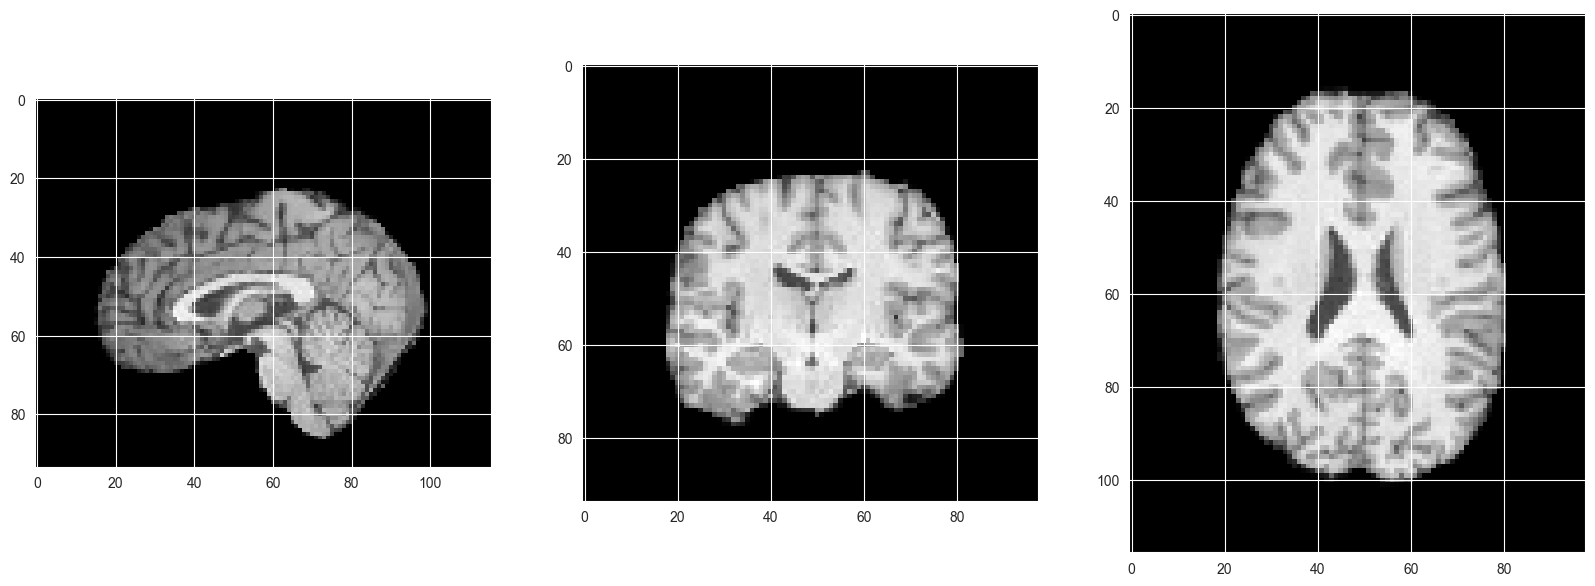

In [16]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [17]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:05<00:00, 120.15it/s]


In [18]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 108618.43it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

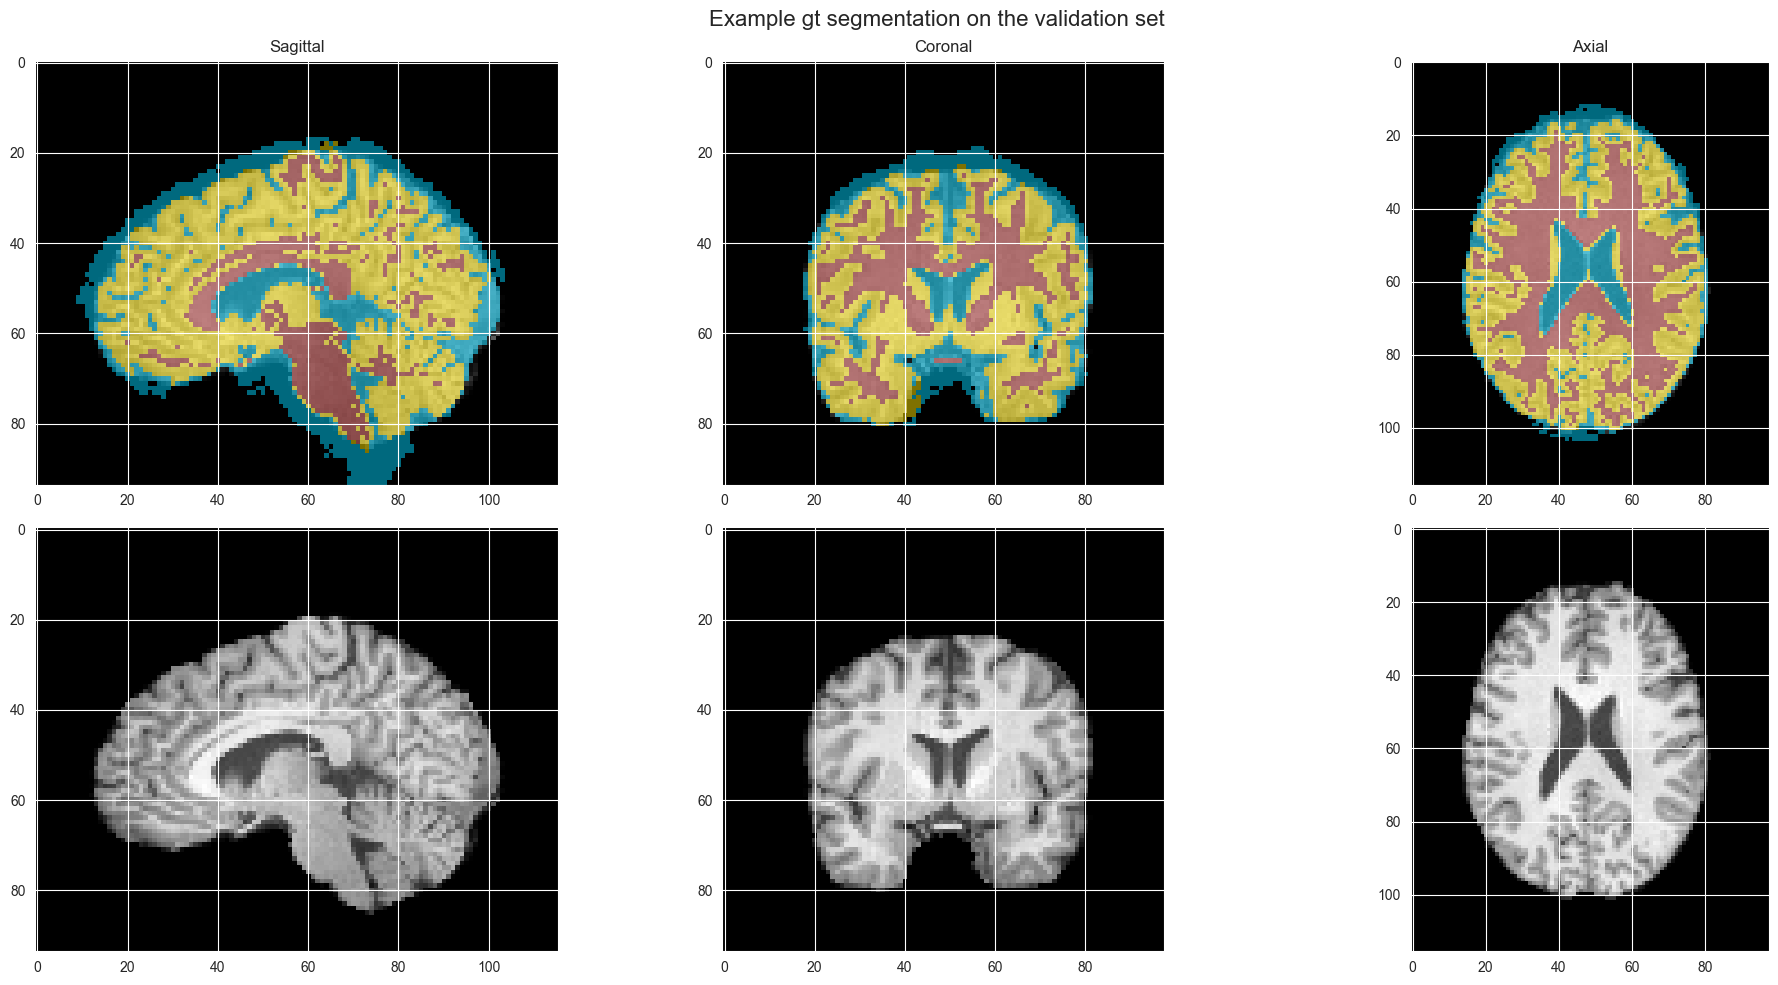

In [19]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Evaluation and Visualization

 We first have to define how good our predicted segmentations are.

In [20]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
def Dice(predictions, gt):
    classes = np.unique(gt)

    dice_scores = []
    for cl in classes:
        inter = np.sum((predictions == cl) & (gt == cl))
        sum = np.sum(predictions == cl) + np.sum(gt == cl)
        # make sure not divided by 0
        dice_score = 2.0 * inter / max(sum, 1)
        dice_scores.append(dice_score)

    mean = round(np.mean(dice_scores),3)
    std = round(np.std(dice_scores),3)

    return mean, std

def precision(predictions, gt):
    classes = np.unique(gt)

    precision_scores = []
    for cl in classes:
        TP = np.sum((predictions == cl) & (gt == cl))
        FP = np.sum((predictions == cl) & (gt != cl))

        precision_score = TP / max(TP + FP, 1)
        precision_scores.append(precision_score)

    mean_precision = round(np.mean(precision_scores),3)
    std_precision = round(np.std(precision_scores),3)

    return mean_precision, std_precision

def recall(predictions, gt):
    classes = np.unique(gt)

    recall_scores = []
    for cl in classes:
        TP = np.sum((predictions == cl) & (gt == cl))
        FN = np.sum((gt == cl) & (predictions != cl))

        recall_score = TP / max(TP + FN, 1)
        recall_scores.append(recall_score)

    mean_recall = round(np.mean(recall_scores),3)
    std_recall = round(np.std(recall_scores),3)

    return mean_recall, std_recall

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [21]:
def get_best_and_worst_ids(predictions, ground_truth):
    best_id, worst_id = -1, -1
    best_performance, worst_performance = float('-inf'), float('inf')

    for i, (pred, gt) in enumerate(zip(predictions, ground_truth)):
        dice_score = Dice(pred, gt)[0]
        if dice_score > best_performance:
            best_performance = dice_score
            best_id = i
        if dice_score < worst_performance:
            worst_performance = dice_score
            worst_id = i

    return {
        'best_id': best_id,
        'best_performance': best_performance,
        'worst_id': worst_id,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, ground_truth, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions, ground_truth)

    best_id = return_dict['best_id']
    worst_id = return_dict['worst_id']

    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

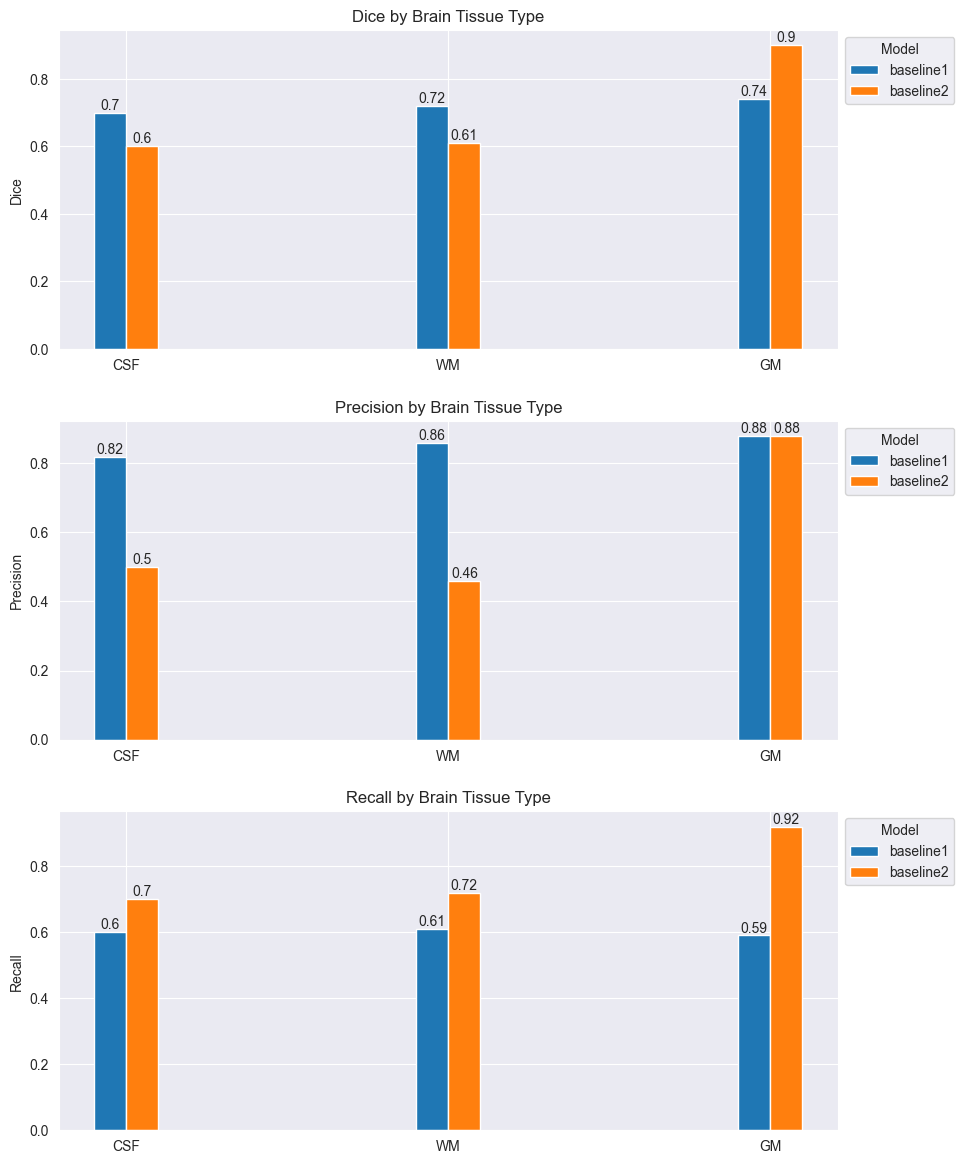

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def get_results_dictionary(predictions, ground_truth):
    results_dict = {}
    tissue_types = {0: 'CSF', 1: 'WM', 2: 'GM'}

    for class_id, tissue_type in tissue_types.items():

        class_preds = [pred == class_id for pred in predictions]
        class_gts = [gt == class_id for gt in ground_truth]

        dice_score, _ = Dice(class_preds, class_gts)
        precision_score, _ = precision(class_preds, class_gts)
        recall_score, _ = recall(class_preds, class_gts)

        results_dict[tissue_type] = {
            'dice': dice_score,
            'precision': precision_score,
            'recall': recall_score
        }

    return results_dict

def plot_results_summary(results_dict):

    metrics = ['dice', 'precision', 'recall']
    tissues = ['CSF', 'WM', 'GM']
    n_models = len(results_dict)
    n_metrics = len(metrics)

    # Create a figure with subplots - one for each metric
    fig, axes = plt.subplots(nrows=n_metrics, ncols=1, figsize=(10, n_metrics * 4))

    # Set the positions and width for the bars
    positions = np.arange(len(tissues))
    width = 0.1  # the width of the bars

    for i, (model_name, tissues_metrics) in enumerate(results_dict.items()):
        offset = (i - n_models / 2) * width + width / 2

        # For each metric, create a bar in the appropriate subplot
        for j, metric in enumerate(metrics):
            values = [float(tissues_metrics[tissue][metric]) for tissue in tissues]
            axes[j].bar(positions + offset, values, width, label=model_name)
            for idx, value in enumerate(values):
                axes[j].text(idx + offset, value + 0.01, str(value), ha='center')

    # Set the labels, titles, ticks, and legends
    for j, metric in enumerate(metrics):
        axes[j].set_ylabel(metric.capitalize())
        axes[j].set_title(f'{metric.capitalize()} by Brain Tissue Type')
        axes[j].set_xticks(positions)
        axes[j].set_xticklabels(tissues)
        axes[j].legend(title="Model", loc='upper left', bbox_to_anchor=(1,1))

    plt.tight_layout(pad=2.0)
    plt.show()

# Sample data
sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}

# Plot the summary
plot_results_summary(sample_results)


# Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

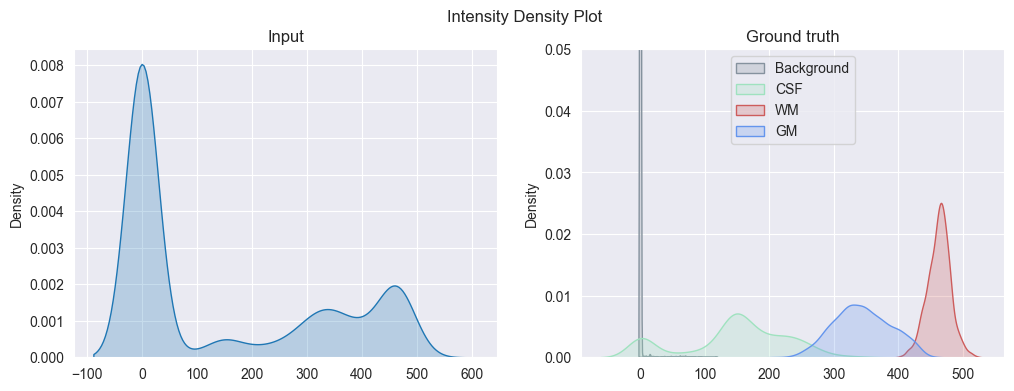

In [23]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

In [24]:
ims_test = [load_nii(file) for file in test_files]
seg_test = np.array(segmentations_test)

In [25]:
def maximize_dice_assignment(pred_seg, seg_list):
    new_pred_seg = np.zeros_like(pred_seg)
    classes = np.unique(seg_list)

    for cl in classes:
        candidate_labels = np.unique(pred_seg)
        best_dice = 0.0
        best_label = None

        for candidate_label in candidate_labels:
            temp_pred_seg = np.where(pred_seg == candidate_label, cl, pred_seg)
            dice, _ = Dice(temp_pred_seg, seg_list)

            if dice > best_dice:
                best_dice = dice
                best_label = candidate_label

        new_pred_seg = np.where(pred_seg == best_label, cl, new_pred_seg)

    return new_pred_seg

In [26]:
# Unsupervised method 1
from sklearn.cluster import KMeans

def unsupervised_method_1(data, labels):

    num_clusters = 4  # Assuming 4 tissue types
    
    # Fit K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(data.reshape(-1, 1))

    return cluster_assignments
# Apply the unsupervised method to the test data

desired_length = len(ims_test)
seg_list_1 = [0] * desired_length
pred_seg_1 = [0] * desired_length

for i in range(len(ims_test)):
    
    im   = ims_test[i].flatten()
    seg  = seg_test[i].flatten()
    pred = unsupervised_method_1(im, seg) 
    
    pred = maximize_dice_assignment(pred, seg)
    
    pred_seg_1[i]=pred
    seg_list_1[i]=seg
# ----------------------------------- END -------------------------------------

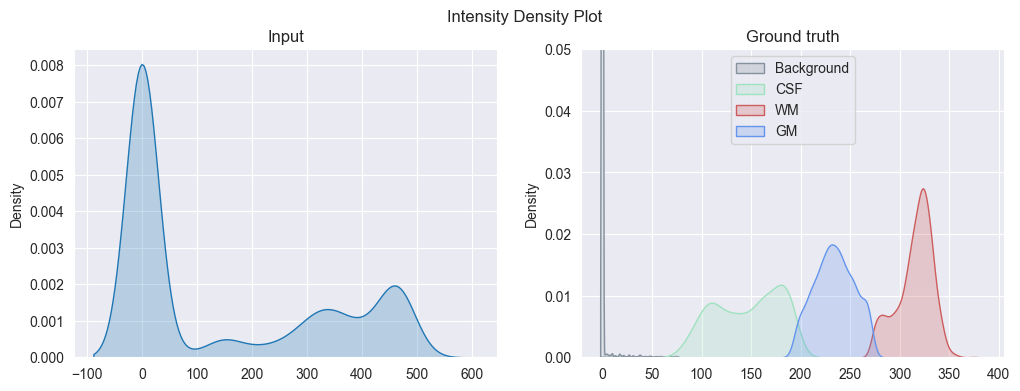

In [27]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
im = ims_test[0][:,:,47].flatten()
seg_shape= ims_test[0].shape
seg = pred_seg_1[0].reshape(seg_shape)
seg = seg[:,:,47].flatten()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

noise = np.random.normal(0, 1e-5, size=im_[np.argwhere(seg == 0)][:, 0].shape)
sns.kdeplot(im[np.argwhere(seg== 0)][:, 0] + noise, ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)

sns.kdeplot(im[np.argwhere(seg== 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im[np.argwhere(seg== 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im[np.argwhere(seg== 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])
# ----------------------------------- END -------------------------------------

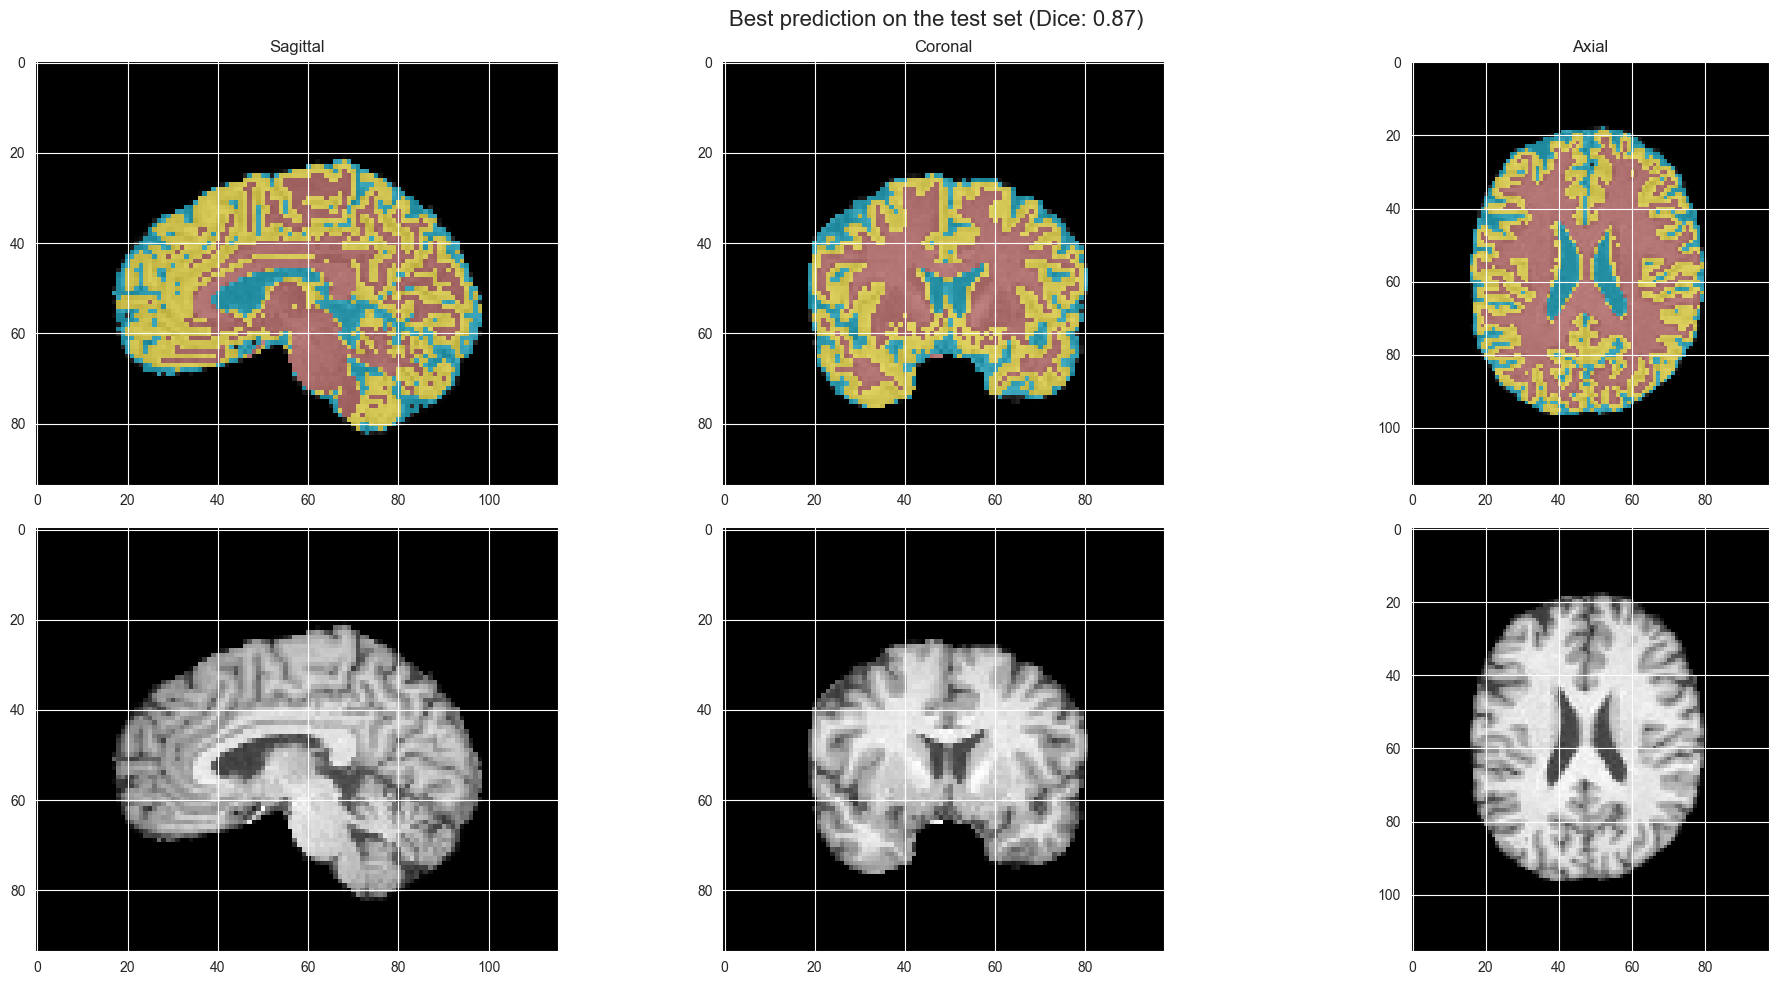

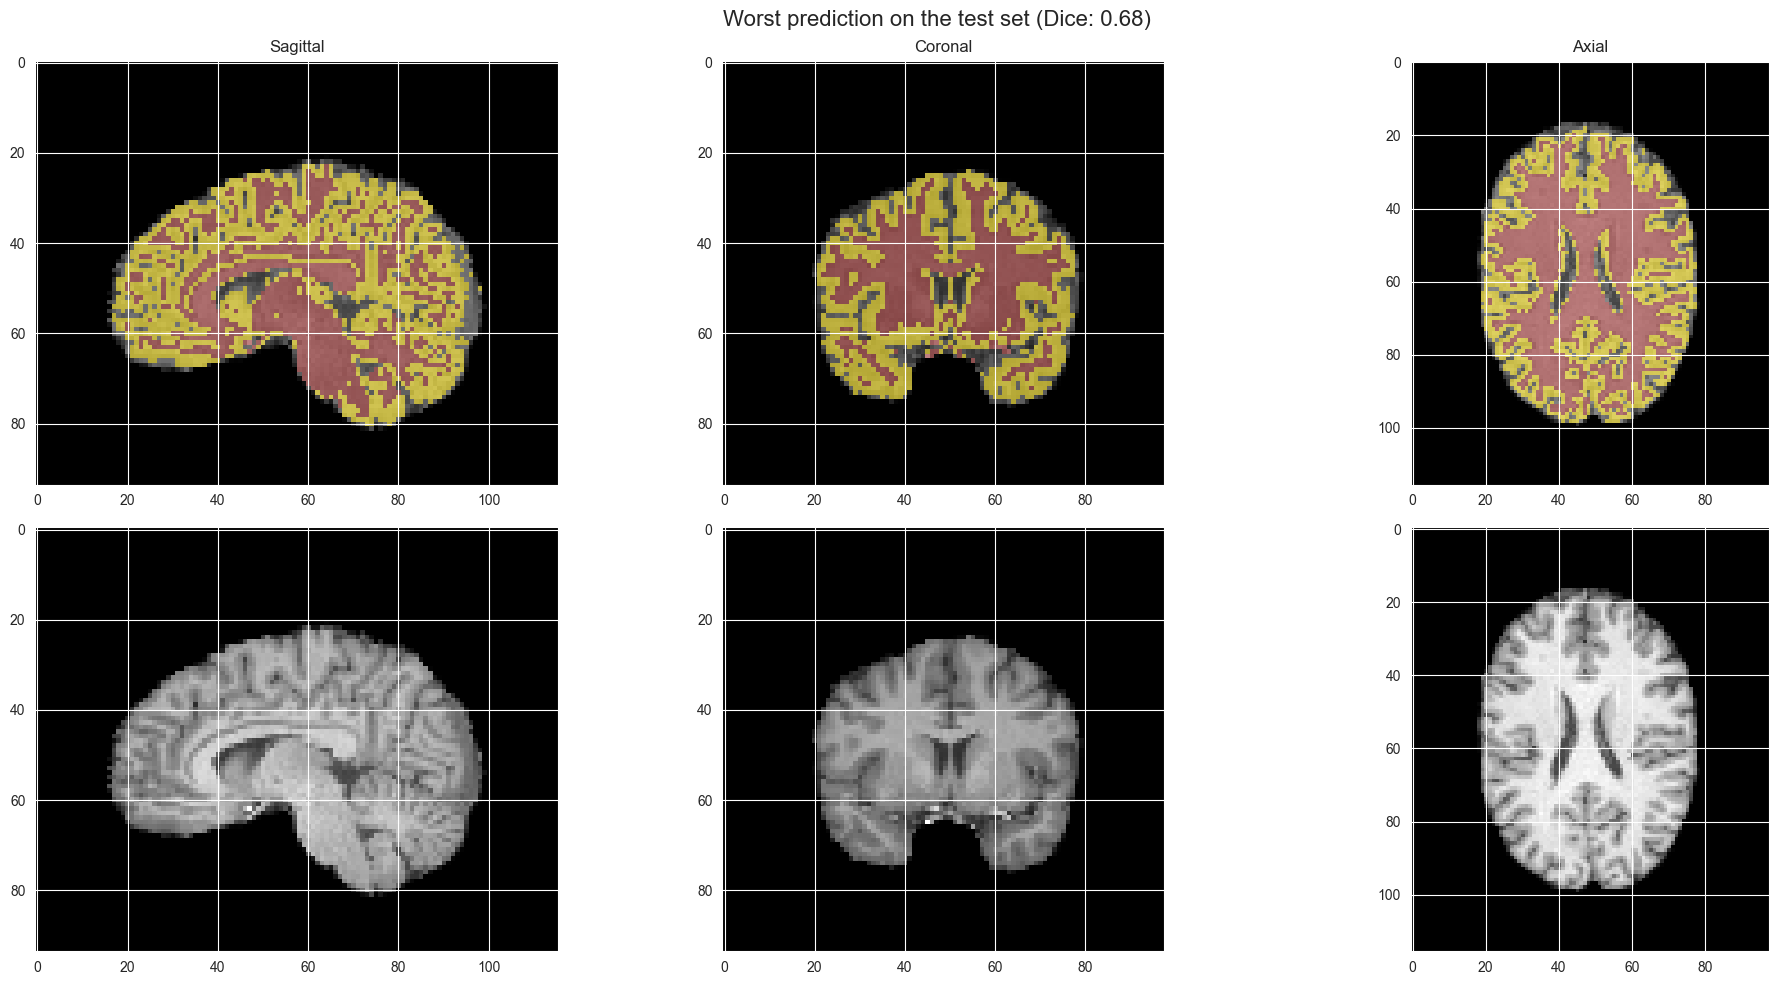

In [28]:
# Visualize the best and worst predictions on the test set for method 1

original_shape = ims_test[0].shape

# Reshape each element in the pred_seg_1 list to the original shape
pred_seg_1 = [item.reshape(original_shape) for item in pred_seg_1]
seg_list_1 = [item.reshape(original_shape) for item in seg_list_1]

visualize_best_and_worst_samples(pred_seg_1,seg_list_1)

a second unsupervised learning method


In [29]:
# Unsupervised method 2
from sklearn.mixture import GaussianMixture

def unsupervised_method_2(data, labels):
    num_clusters = 4  
    gmm = GaussianMixture(n_components=num_clusters, random_state=10)
    cluster_assignments = gmm.fit_predict(data.reshape(-1, 1))
    return cluster_assignments

desired_length = len(ims_test)
seg_list_2 = [0] * desired_length
pred_seg_2 = [0] * desired_length


for i in range(len(ims_test)):
    
    im   = ims_test[i].flatten()
    seg  = seg_test[i].flatten()
    pred = unsupervised_method_2(im, seg)
    pred = maximize_dice_assignment(pred, seg)

    pred_seg_2[i]=pred
    seg_list_2[i]=seg


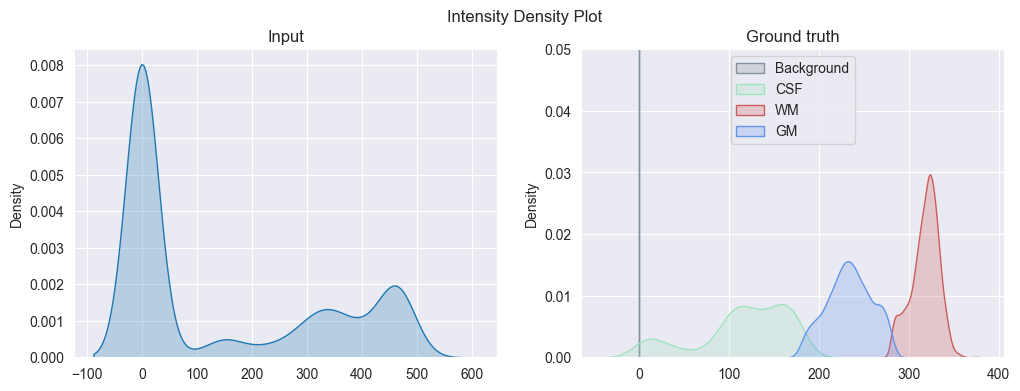

In [30]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)

im = ims_test[0][:,:,47].flatten()

seg_shape= ims_test[0].shape
seg = pred_seg_2[0].reshape(seg_shape)
seg = seg[:,:,47].flatten()


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

noise = np.random.normal(0, 1e-5, size=im_[np.argwhere(seg == 0)][:, 0].shape)
sns.kdeplot(im[np.argwhere(seg== 0)][:, 0]+ noise, ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)

sns.kdeplot(im[np.argwhere(seg== 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im[np.argwhere(seg== 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im[np.argwhere(seg== 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])
# ----------------------------------- END -------------------------------------

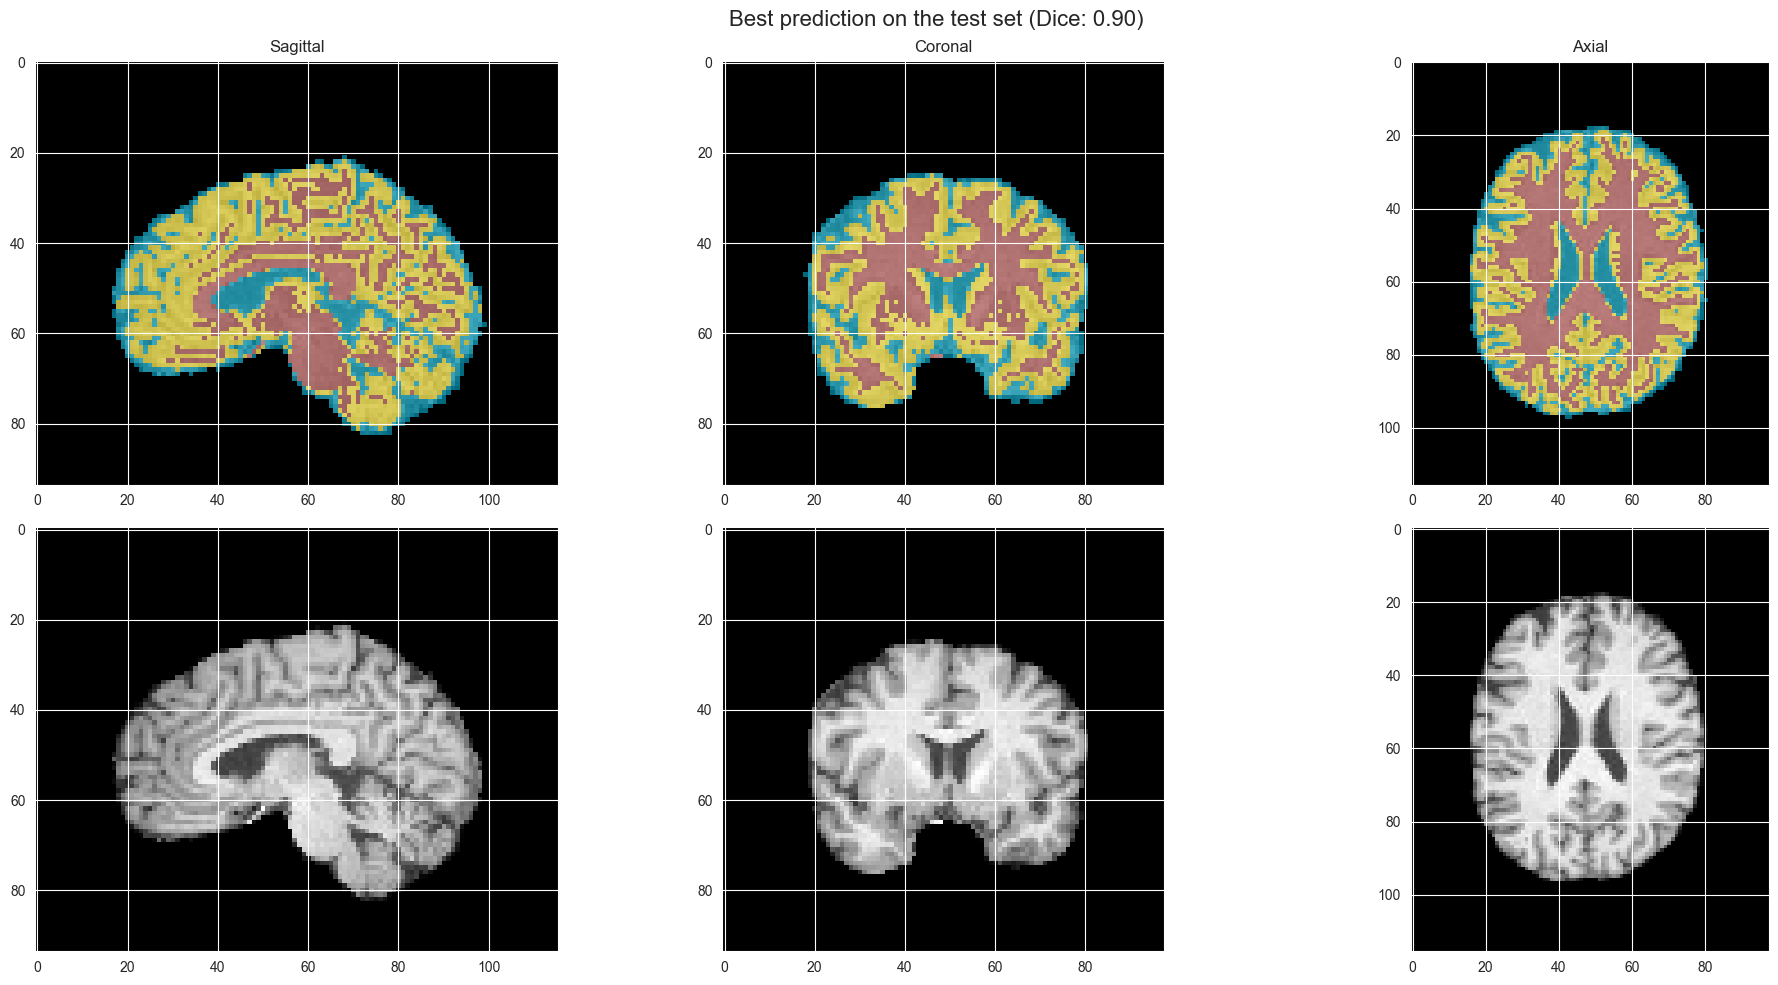

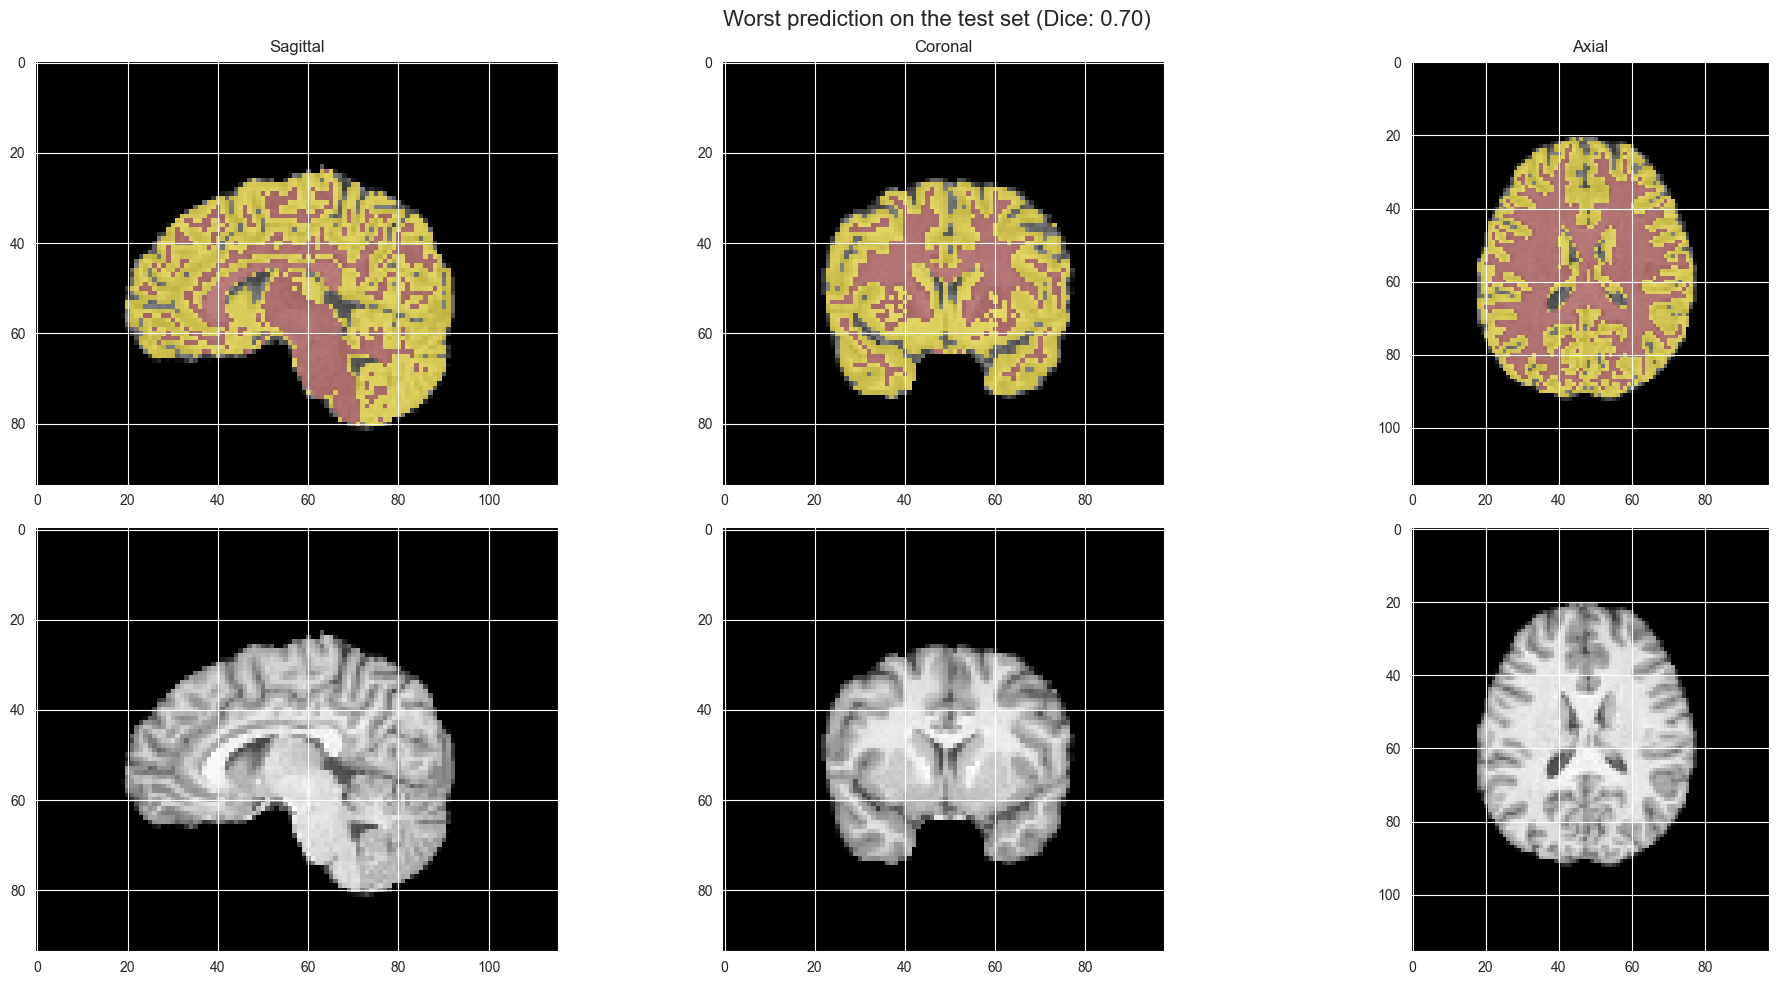

In [31]:
# Visualize the best and worst predictions on the test set for method 1

original_shape = ims_test[0].shape

# Reshape each element in the pred_seg_1 list to the original shape
pred_seg_2 = [item.reshape(original_shape) for item in pred_seg_2]
seg_list_2 = [item.reshape(original_shape) for item in seg_list_2]

visualize_best_and_worst_samples(pred_seg_2,seg_list_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

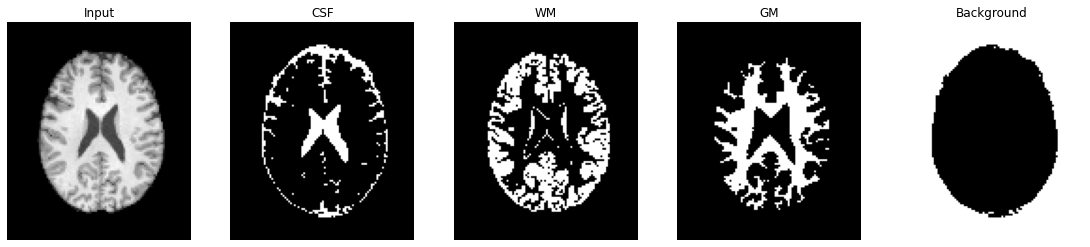

In [18]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

In [19]:
# Define and train a neural network (U-Net) with only 1 skip-connection on the bottom layer for segmentation
# Implement
# gray image, so the in_channels and out_channels are both 1.
from torch import nn as nn
# for performance reason, use DepthwiseSeparableConv3d instead of normal Conv3d.
class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [20]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)


In [21]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        self.down1 = nn.Sequential(
            DepthwiseSeparableConv3d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            SEBlock(16)
        )
        self.down2 = nn.Sequential(
            DepthwiseSeparableConv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            SEBlock(32)
        )

        self.down3 = nn.Sequential(
            DepthwiseSeparableConv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            SEBlock(64)
        )

        self.bottleneck = nn.Sequential(
            DepthwiseSeparableConv3d(64, 96, kernel_size=3, padding=1),
            nn.BatchNorm3d(96),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv3d(96, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.Sequential(
            DepthwiseSeparableConv3d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.Sequential(
            DepthwiseSeparableConv3d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )

        self.up3 = nn.Sequential(
            DepthwiseSeparableConv3d(32, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        bottleN = self.bottleneck(down3)
        up_input = torch.cat([down3, bottleN], dim=1)  # Skip-connection
        up1 = self.up1(up_input)
        up2 = self.up2(up1)
        up3 = self.up3(up2)
        return up3


In [22]:
#define parameters
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

device = torch.device('cuda')
num_epochs = 30
model = UNet3D(in_channels=1, out_channels=4).to(device)
learningrate = 0.002
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=learningrate)

In [23]:
import numpy as np
import torch

ims_train = [load_nii(im_file_train) for im_file_train in train_files]
ims_val = [load_nii(im_file_val) for im_file_val in val_files]

ims_train = torch.tensor(np.array(ims_train)).unsqueeze(1).float()
ims_val = torch.tensor(np.array(ims_val)).unsqueeze(1).float()

seg_train = torch.tensor(np.array(segmentations_train)).long()
seg_val = torch.tensor(np.array(segmentations_val)).long()

onehot_seg_train = torch.nn.functional.one_hot(seg_train, num_classes=4).permute(0,4,1,2,3)
onehot_seg_val = torch.nn.functional.one_hot(seg_val, num_classes=4).permute(0,4,1,2,3)

In [24]:
class ImageSegDataset(Dataset):
    def __init__ (self, image, seg, transform = None):
        self.image = image
        self.seg = seg
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__ (self, idx):
        if self.transform:
            self.image, self.seg = self.transform(self.image, self.seg)


        return {'image': self.image[idx], 'seg': self.seg[idx]}


dataset_train = ImageSegDataset(ims_train, seg_train)
dataset_val = ImageSegDataset(ims_val, seg_val)
dataloader_imseg = DataLoader(dataset_train, batch_size = 2, shuffle=True)
dataloader_imseg_val = DataLoader(dataset_val, batch_size = 2, shuffle=True)

In [25]:
ims_test = [load_nii(file) for file in test_files]
seg_test = torch.tensor(np.array(segmentations_test)).float()

ims_test = torch.tensor(ims_test).unsqueeze(1).float()
onehot_seg_test = torch.nn.functional.one_hot(seg_test.to(torch.int64), num_classes=4).permute(0, 4, 1, 2, 3)

dataset_test = ImageSegDataset(ims_test, onehot_seg_test)

dataloader_imseg_test = DataLoader(dataset_test, batch_size=2, shuffle=False)

/tmp/ipykernel_4475/2409027324.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  ims_test = torch.tensor(ims_test).unsqueeze(1).float()


In [26]:
#trainning_loop
def train(dataloader_imseg, dataloader_val, model):
    loss_values = []
    val_loss_values = []
    scaler = GradScaler()

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        torch.cuda.empty_cache()

        with tqdm(total=len(dataloader_imseg), desc=f'Epoch {epoch}/{num_epochs}', unit='batch') as tepoch:
            for batch in dataloader_imseg:
                images, labels = batch['image'].to(device), batch['seg'].to(device)
                optimizer.zero_grad()

                #mixed precision training
                with autocast():
                        outputs = model(images)
                        train_loss = loss(outputs, labels)
                scaler.scale(train_loss).backward()
                scaler.step(optimizer)
                scaler.update()

                epoch_loss += train_loss.item()
                tepoch.set_postfix(loss=epoch_loss / (tepoch.n + 1))
                tepoch.update()

        avg_train_loss = epoch_loss / len(dataloader_imseg)
        loss_values.append(avg_train_loss)
        avg_val_loss = evaluate(dataloader_val, model)
        val_loss_values.append(avg_val_loss)

        print(f'Epoch [{epoch}/{num_epochs}] - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}')

    return loss_values, val_loss_values, model

def evaluate(dataloader, model):
    model.eval()
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch['image'].to(device), batch['seg'].to(device)
            outputs = model(images)
            batch_loss = loss(outputs, labels)
            total_loss += batch_loss.item()
            total_batches += 1

    average_loss = total_loss / total_batches
    return average_loss

## training

In [27]:
"""
loss_values, val_loss_values, trained_model = train(dataloader_imseg=dataloader_imseg, dataloader_val=dataloader_imseg_val,model=model)

plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()trained_

torch.save(model.state_dict(), 'trained_model.pth')
"""
model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [28]:
#create ground_truth_labels and pred_seg_3
pred_seg_3 = []
ground_truth = []
for batch in dataloader_imseg_test:
    images = batch['image'].to(device)
    labels = batch['seg'].to(device)
    ground_truth.extend(labels.cpu().numpy())
    #convert it from 4-dimension to 3 dimension, makes ground_truth comparable with predictions
    ground_truth_labels = [np.argmax(gt, axis=0) for gt in ground_truth]

    with torch.no_grad():
        output = model(images)
        preds = torch.argmax(output, dim=1).cpu().numpy()

        for pred in preds:
            pred_seg_3.append(pred)

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

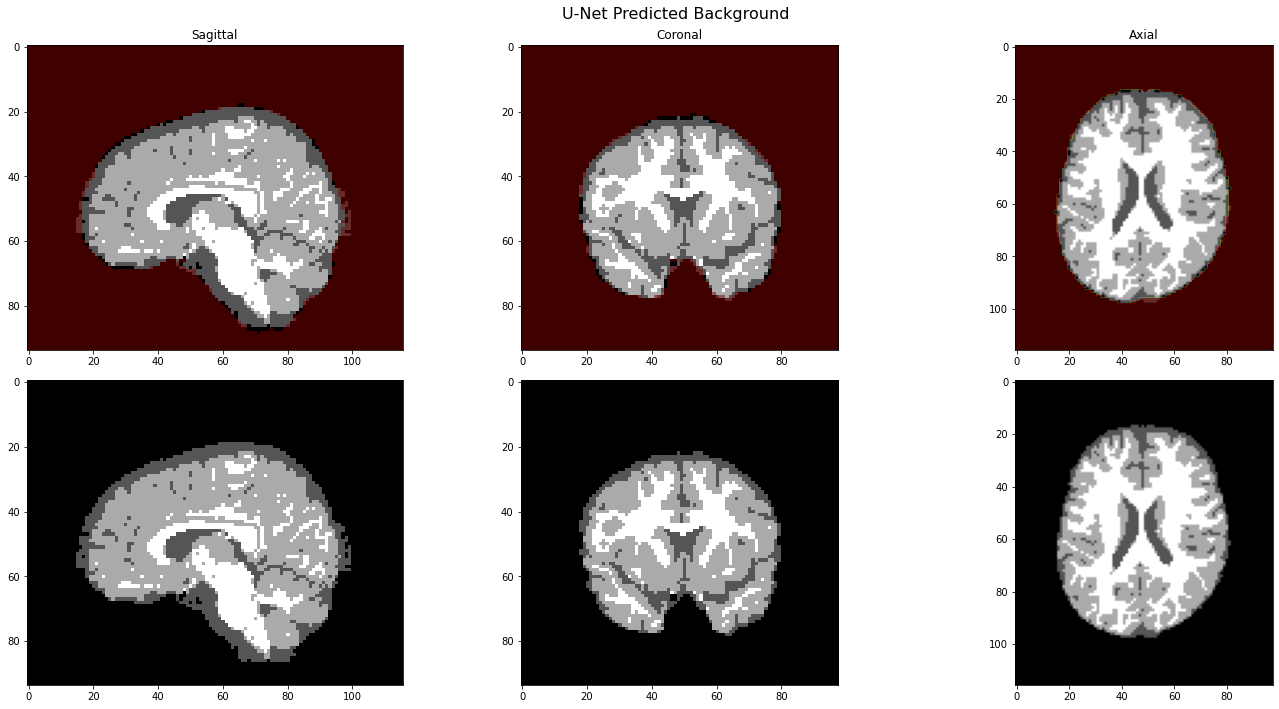

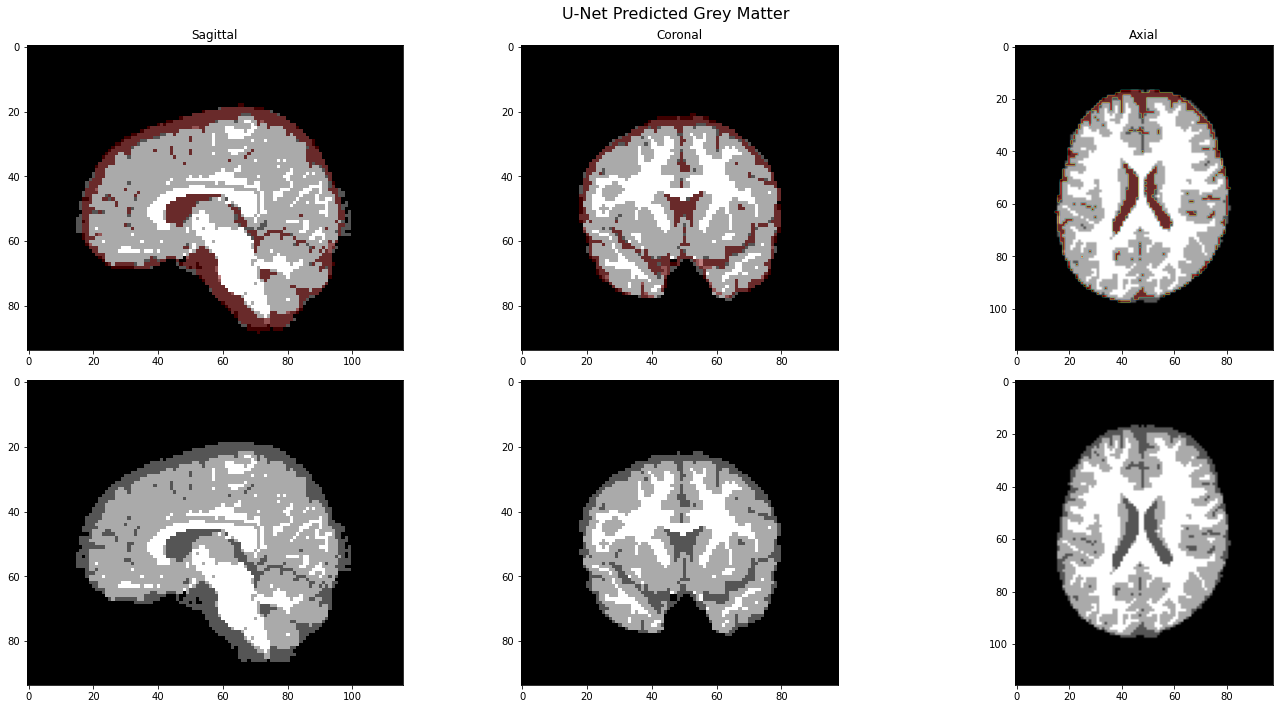

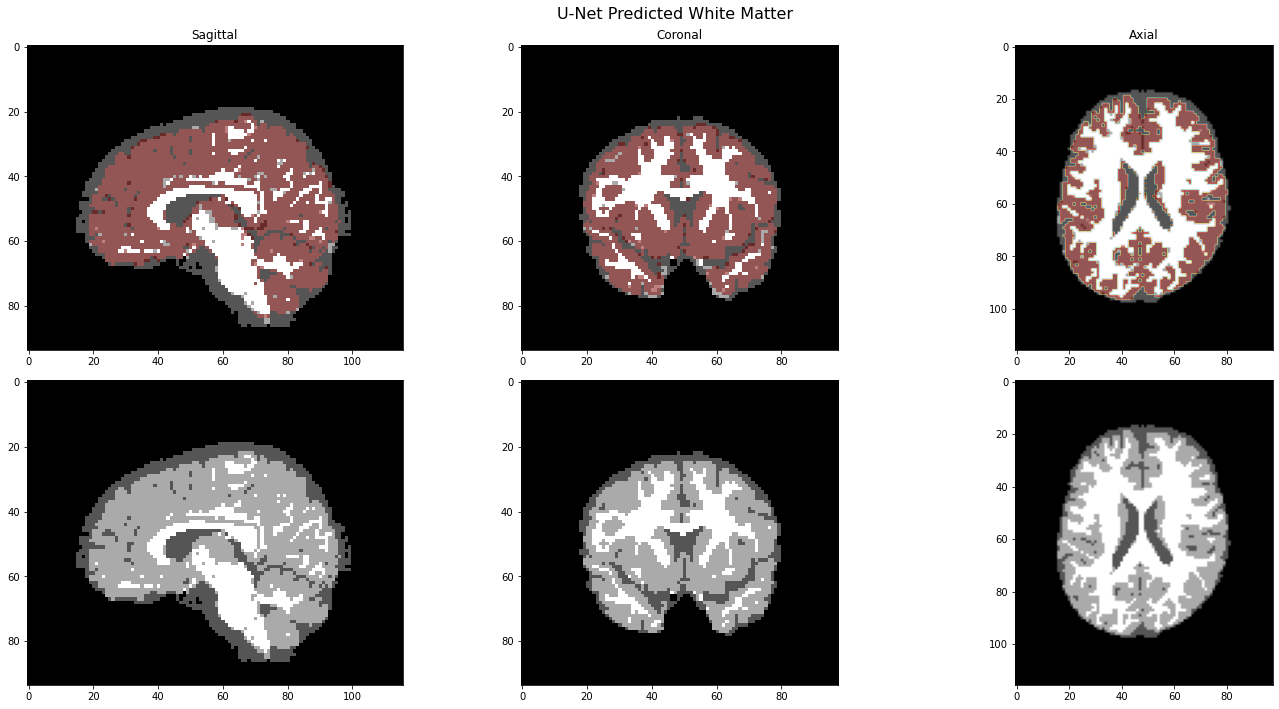

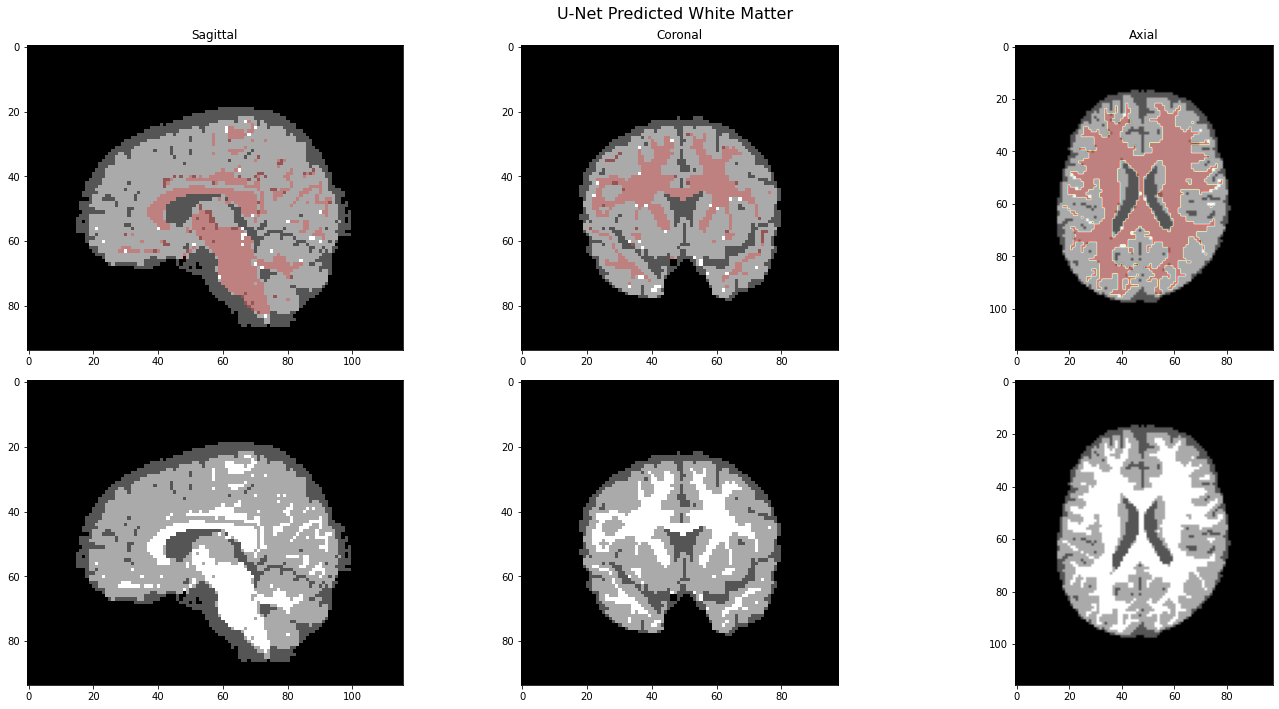

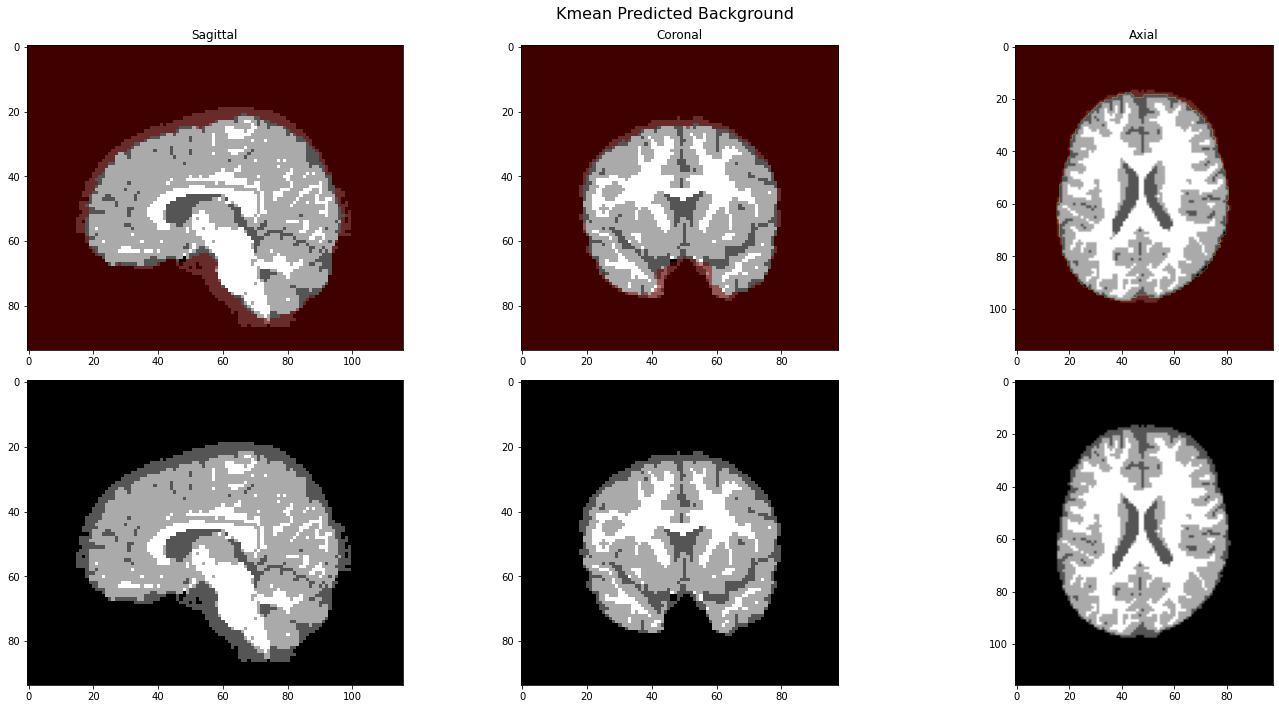

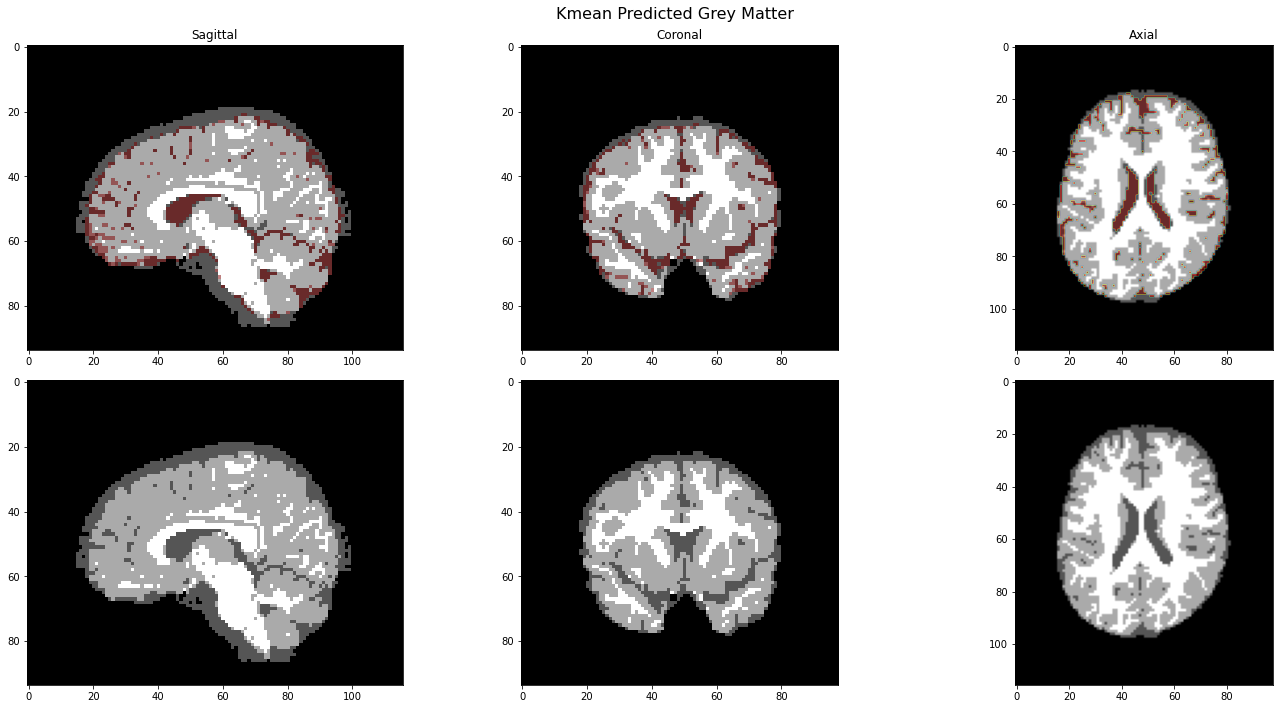

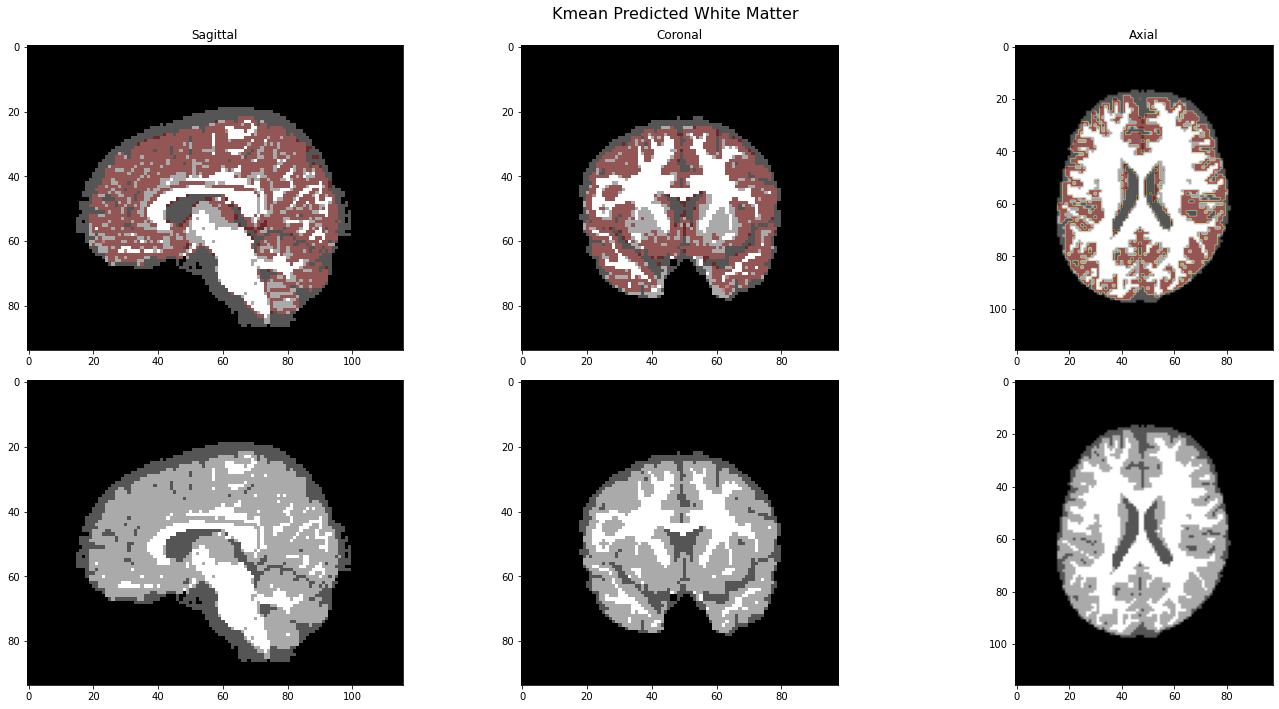

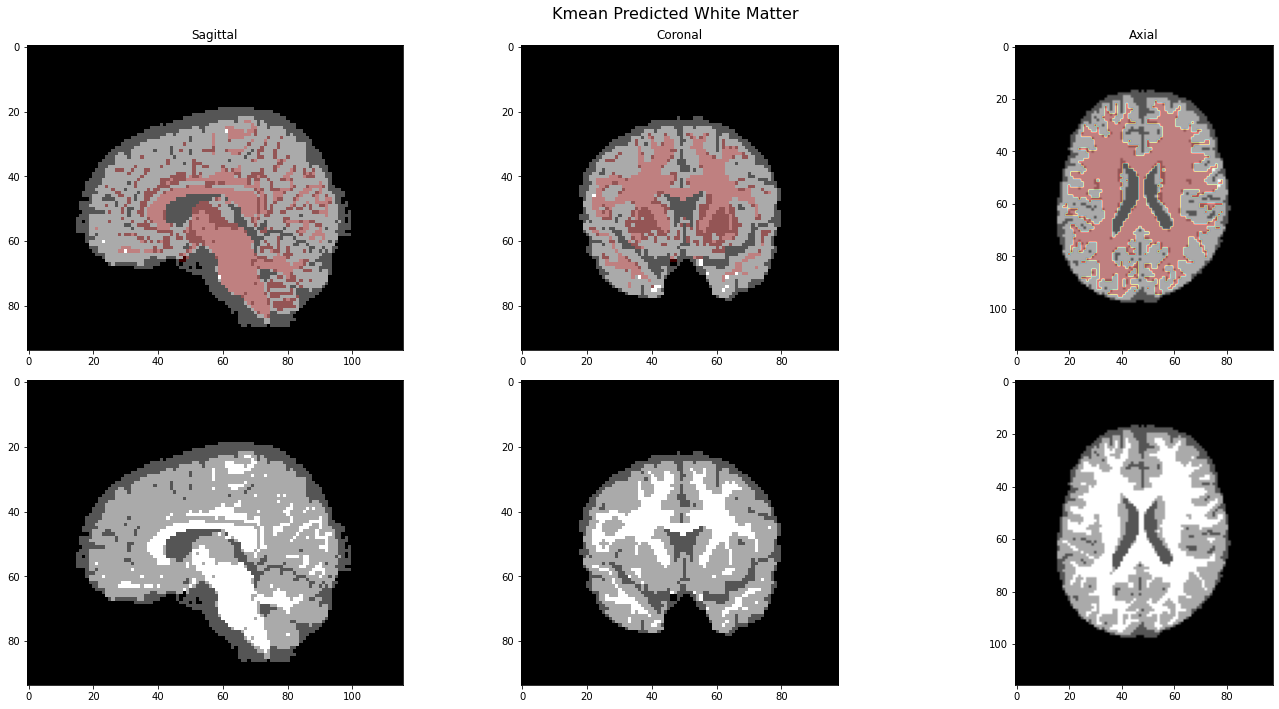

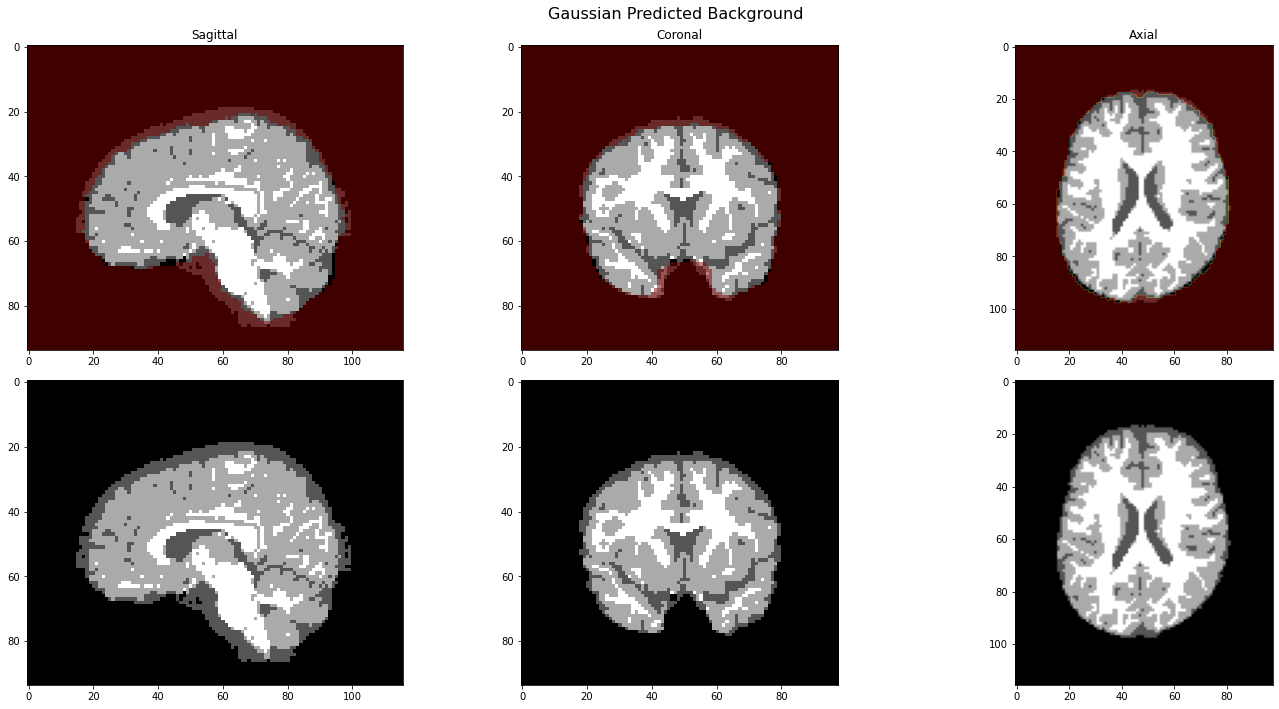

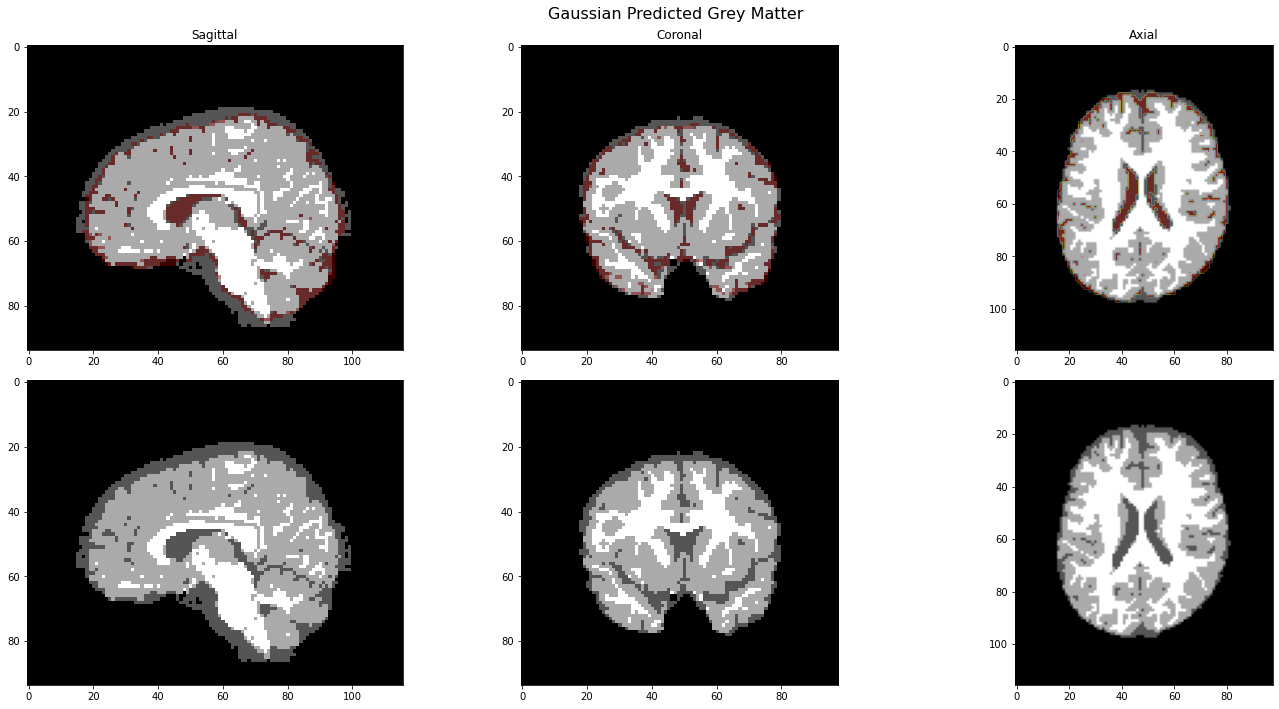

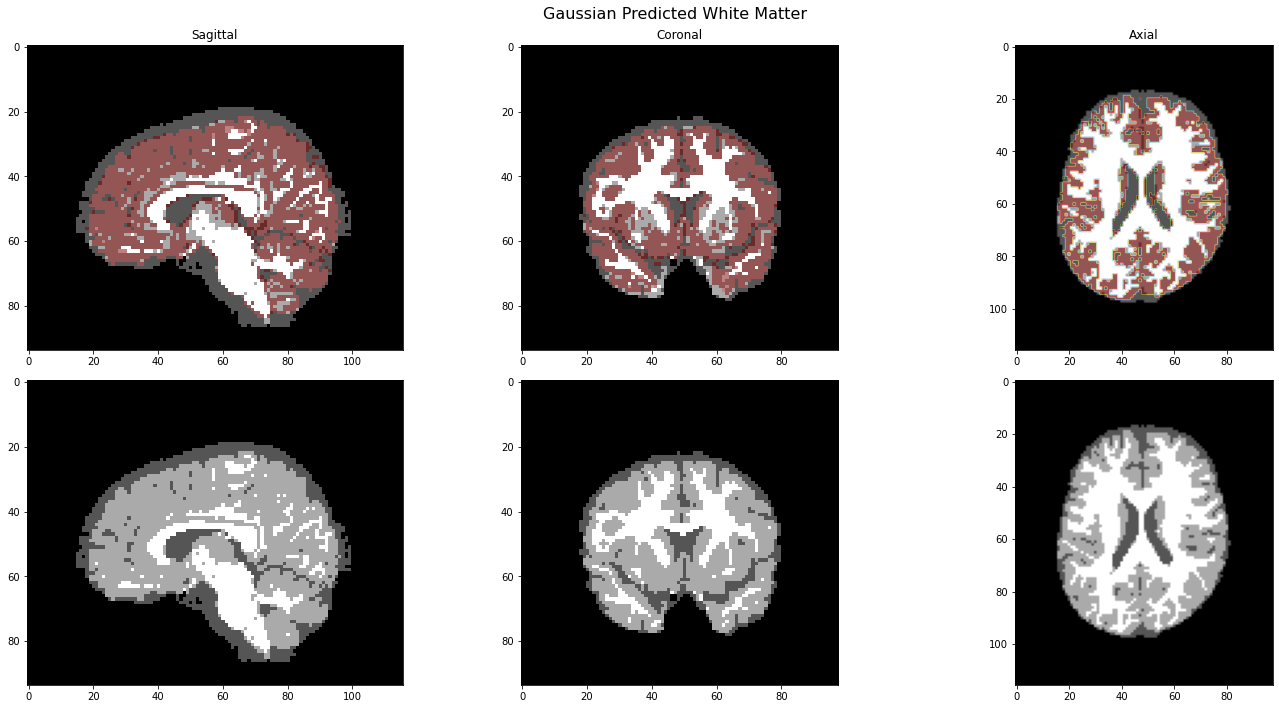

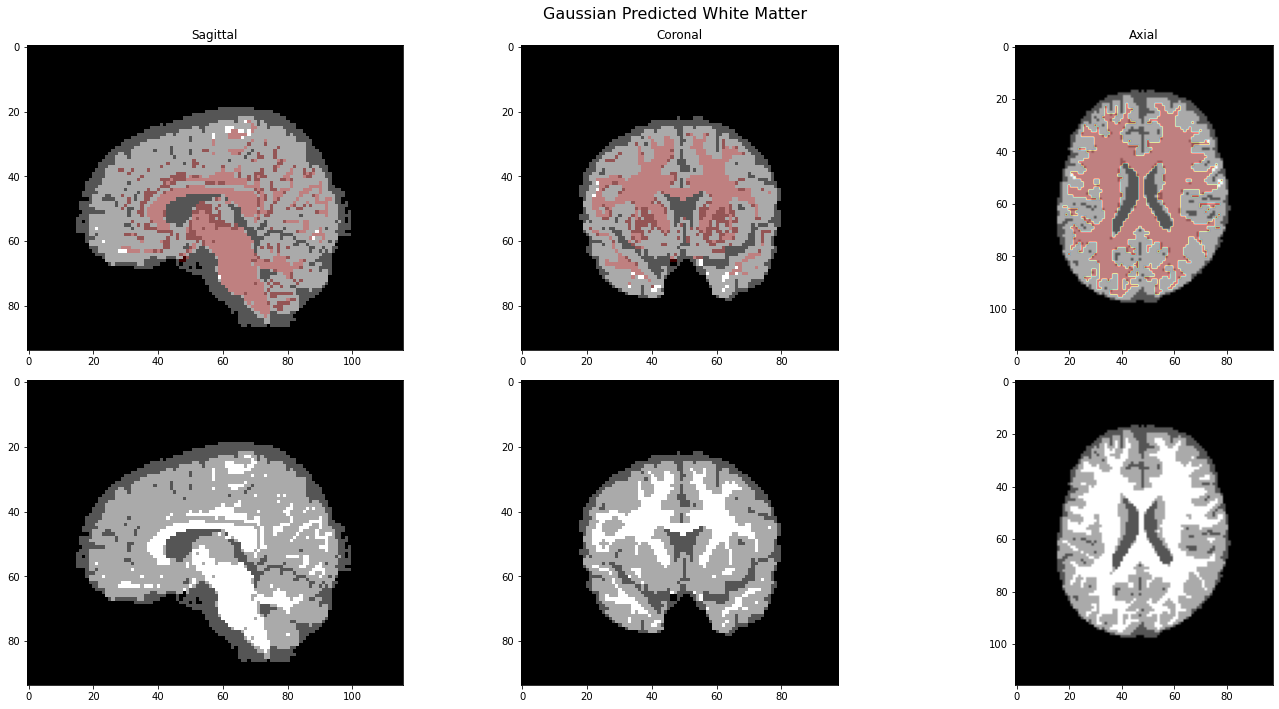

In [52]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None

# load
im = load_nii(test_files[0])
im = torch.tensor(im).unsqueeze(0).unsqueeze(0)  # 5D tensor：batch size, channels, depth, height, width
im = im.to(device, dtype=torch.float)
seg = segmentations_test[0]
model.eval()
with torch.no_grad():
    pred = model(im)
    pred = torch.argmax(pred, dim=1).cpu().numpy()
plt_gt = plot_segmentations(seg, pred[0]==0, i=47, title='U-Net Predicted Background')
plt_seg_1 = plot_segmentations(seg, pred[0]==1, i=47, title='U-Net Predicted Grey Matter')
plt_seg_2 = plot_segmentations(seg, pred[0]==2, i=47, title='U-Net Predicted White Matter')
plt_seg_3 = plot_segmentations(seg, pred[0]==3, i=47, title='U-Net Predicted White Matter')

p1 = pred_seg_1[0]

plt_gt = plot_segmentations(seg, p1==0, i=47, title='Kmean Predicted Background')
plt_seg_1 = plot_segmentations(seg, p1==1, i=47, title='Kmean Predicted Grey Matter')
plt_seg_2 = plot_segmentations(seg, p1==2, i=47, title='Kmean Predicted White Matter')
plt_seg_3 = plot_segmentations(seg, p1==3, i=47, title='Kmean Predicted White Matter')

p2 = pred_seg_2[0]
plt_gt = plot_segmentations(seg, p2==0, i=47, title='Gaussian Predicted Background')
plt_seg_1 = plot_segmentations(seg, p2==1, i=47, title='Gaussian Predicted Grey Matter')
plt_seg_2 = plot_segmentations(seg, p2==2, i=47, title='Gaussian Predicted White Matter')
plt_seg_3 = plot_segmentations(seg, p2==3, i=47, title='Gaussian Predicted White Matter')
# ----------------------------------- END -------------------------------------

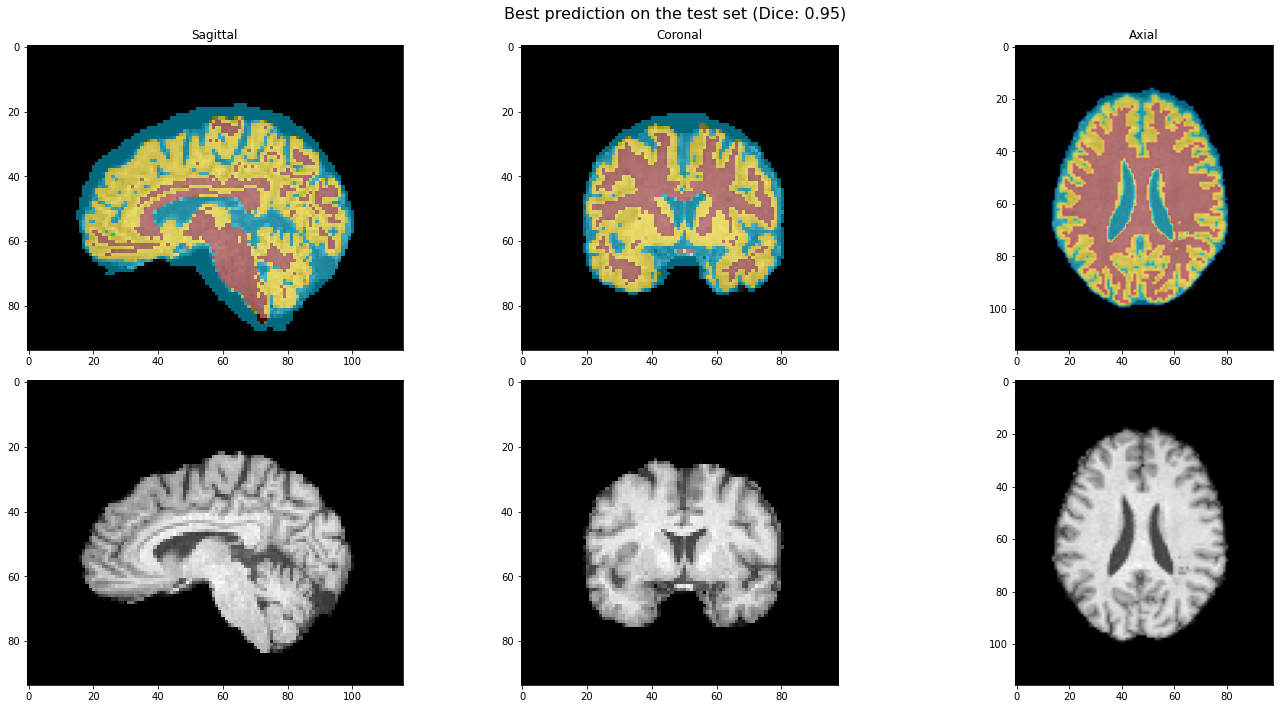

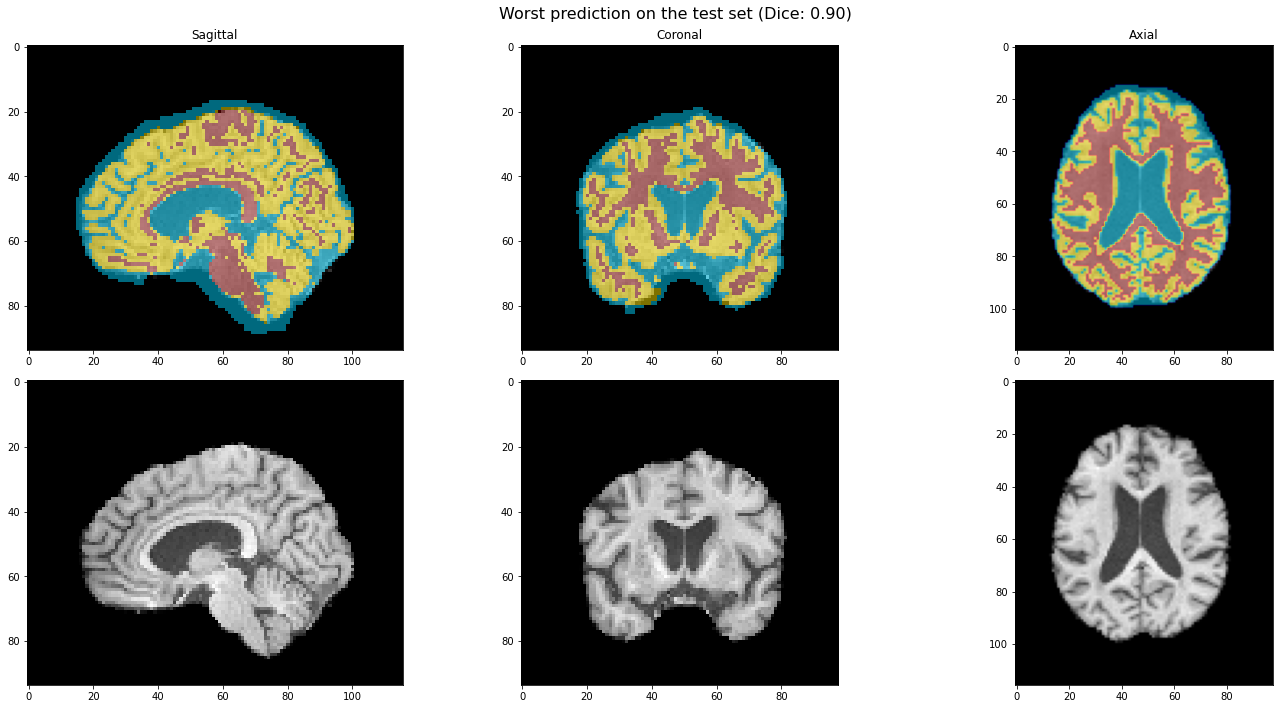

In [30]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3,ground_truth_labels)

### Summarize the results of all of the segmentation methods implemented.

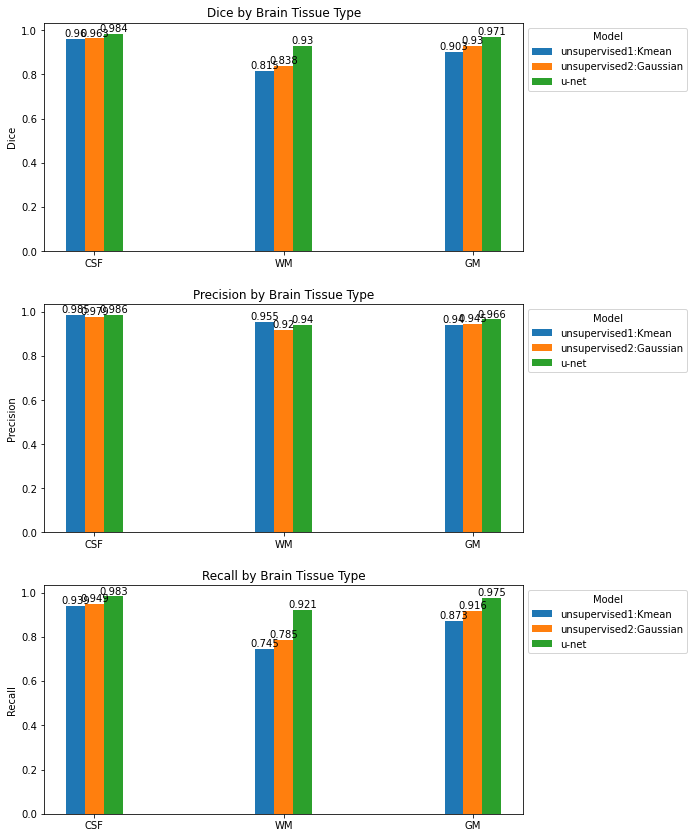

In [31]:
# Run this block after implementing Q1-3.
results_dictionary = {
#完成后解除注释来测试
    'unsupervised1:Kmean': get_results_dictionary(pred_seg_1, ground_truth_labels),
    'unsupervised2:Gaussian': get_results_dictionary(pred_seg_2, ground_truth_labels),
    'u-net': get_results_dictionary(pred_seg_3,ground_truth_labels),
}
plot_results_summary(results_dictionary)